In [1]:
import os
import pickle
from pathlib import Path
from typing import Any
from warnings import catch_warnings, simplefilter

import matplotlib.pyplot as plt
import numpy as np
import scienceplots
from ultralytics import YOLO

# Constants
CURRENT_DIR = os.getcwd()
FINAL_MODELS_DIR = os.path.join(CURRENT_DIR, "final_models")
ORIGINAL_MODELS_DIR = os.path.join(CURRENT_DIR, "original_models")
PLOTS_DIR = os.path.join(CURRENT_DIR, "plots")
RUNS_DIR = os.path.join(CURRENT_DIR, "runs", "val")
FIGSIZE = (4, 3)

# Plot style configuration
plt.style.use(["science", "ieee"])

# Only for plt.show() visualization
plt.rcParams.update({"figure.dpi": "100"})

# Set up font sizes of the plots
# SMALL_SIZE = 8
# MEDIUM_SIZE = 10
# BIGGER_SIZE = 12

# plt.rc("font", size=SMALL_SIZE)  # controls default text sizes
# plt.rc("axes", titlesize=MEDIUM_SIZE)  # fontsize of the axes title
# plt.rc("axes", labelsize=MEDIUM_SIZE)  # fontsize of the x and y labels
# plt.rc("xtick", labelsize=MEDIUM_SIZE)  # fontsize of the tick labels
# plt.rc("ytick", labelsize=MEDIUM_SIZE)  # fontsize of the tick labels
# plt.rc("legend", fontsize=MEDIUM_SIZE)  # legend fontsize
# plt.rc("figure", titlesize=BIGGER_SIZE)  # fontsize of the figure title


def ensure_directory_exists(directory: str, raise_error=False) -> None:
    """Ensure that a directory exists. If it doesn't, this function will create it."""
    if not os.path.exists(directory):
        if raise_error:
            raise AssertionError("No runs/val found in current folder!")
        os.makedirs(directory)


def load_plot_data_from(folder, pickle_name="plot_data.pickle") -> Any:
    """Loads the data needed for plotting from the given `folder`."""
    if not os.path.exists(folder / pickle_name):
        return None

    with open(folder / pickle_name, "rb") as f:
        return pickle.load(f)


ensure_directory_exists(PLOTS_DIR)
ensure_directory_exists(RUNS_DIR, raise_error=True)

In [2]:
MODEL_NAMES = YOLO(Path(FINAL_MODELS_DIR) / "yolov9c_finetuned.pt").names
print(MODEL_NAMES)

{0: 'person', 1: 'bicycle', 2: 'car', 3: 'motorcycle', 4: 'airplane', 5: 'bus', 6: 'train', 7: 'truck', 8: 'boat', 9: 'traffic light', 10: 'fire hydrant', 11: 'stop sign', 12: 'parking meter', 13: 'bench', 14: 'bird', 15: 'cat', 16: 'dog', 17: 'horse', 18: 'sheep', 19: 'cow', 20: 'elephant', 21: 'bear', 22: 'zebra', 23: 'giraffe', 24: 'backpack', 25: 'umbrella', 26: 'handbag', 27: 'tie', 28: 'suitcase', 29: 'frisbee', 30: 'skis', 31: 'snowboard', 32: 'sports ball', 33: 'kite', 34: 'baseball bat', 35: 'baseball glove', 36: 'skateboard', 37: 'surfboard', 38: 'tennis racket', 39: 'bottle', 40: 'wine glass', 41: 'cup', 42: 'fork', 43: 'knife', 44: 'spoon', 45: 'bowl', 46: 'banana', 47: 'apple', 48: 'sandwich', 49: 'orange', 50: 'broccoli', 51: 'carrot', 52: 'hot dog', 53: 'pizza', 54: 'donut', 55: 'cake', 56: 'chair', 57: 'couch', 58: 'potted plant', 59: 'bed', 60: 'dining table', 61: 'toilet', 62: 'tv', 63: 'laptop', 64: 'mouse', 65: 'remote', 66: 'keyboard', 67: 'cell phone', 68: 'microw

In [3]:
data_dict = {}
confusion_matrix_dict = {}

# Load data from each folder
for folder in Path(RUNS_DIR).iterdir():
    if folder.is_dir():
        print(f"Found {folder}... ", end="")
        unpickled_data = load_plot_data_from(folder)
        unpickled_cm = load_plot_data_from(folder, "confusion_matrix_data.pickle")
        if unpickled_data:
            data_dict[folder.name] = unpickled_data
            confusion_matrix_dict[folder.name] = unpickled_cm
            print(f"Found plot data with keys={unpickled_data.keys()}")
        else:
            print("Not found plot data!")

print()

# Create a Legend mapping
new_data_dict = data_dict.copy()
for key in new_data_dict:
    new_key = key.split("_")[-1].capitalize()
    data_dict[new_key] = data_dict.pop(key)
    confusion_matrix_dict[new_key] = confusion_matrix_dict.pop(key)
    print(f"{key} --> {new_key}")

del new_data_dict

Found /home/camilo/Repositorios/hlcv/Project/src/fretboard-recognition/runs/val/yolov9c_original_model_baseline... Found plot data with keys=dict_keys(['px', 'py', 'f1', 'p', 'r', 'ap'])
Found /home/camilo/Repositorios/hlcv/Project/src/fretboard-recognition/runs/val/yolov9c_finetuned... Found plot data with keys=dict_keys(['px', 'py', 'f1', 'p', 'r', 'ap'])

yolov9c_original_model_baseline --> Baseline
yolov9c_finetuned --> Finetuned


In [4]:
def savefig(fig: Any, filename: str | None, format: str, **kwargs) -> None:
    if not filename:
        return
    if not filename.endswith(f".{format}"):
        filename += f".{format}"
    save_path = Path(PLOTS_DIR) / filename
    fig.savefig(save_path, format=format, **kwargs)


def plot_combined_pr_curve(data_dict: dict, filename="combined_pr_curve", format="pdf", show=True):
    # Precision-recall curve
    fig, ax = plt.subplots(1, 1, figsize=FIGSIZE, tight_layout=True)

    for folder, data in data_dict.items():
        px, py = data["px"], data["py"]
        names = data.get("names", None) or MODEL_NAMES
        ap = data["ap"]
        py = np.stack(py, axis=1)
        if names and 0 < len(names) < 21:  # display per-class legend if < 21 classes
            for i, y in enumerate(py.T):
                ax.plot(
                    px, y, linewidth=1, label=f"{names[i]} {ap[i, 0]:.3f}"
                )  # plot(recall, precision)
        else:
            # ax.plot(px, py, linewidth=1, color="grey", label=folder)  # plot(recall, precision)
            ax.plot(
                px,
                py.mean(1),
                label=f"{folder} (all classes {ap[:, 0].mean():.2f} mAP@0.5)",
            )

    ax.set_xlabel("Recall")
    ax.set_ylabel("Precision")
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)
    # ax.legend(loc="upper center", bbox_to_anchor=(0.5, -0.1), fancybox=True, shadow=True, ncol=5)
    ax.legend()
    ax.set_title("Precision-Recall Curve")
    plt.tight_layout()
    savefig(fig, filename, format, bbox_inches="tight")
    if show:
        plt.show()
    plt.close(fig)


def plot_combined_mc_curve(
    data_dict: dict,
    xlabel="Confidence",
    ylabel="Metric",
    key=None,
    filename="combined_mc_curve",
    format="pdf",
    show=True,
):
    fig, ax = plt.subplots(1, 1, figsize=FIGSIZE, tight_layout=True)

    for folder, data in data_dict.items():
        px = data["px"]
        if key is None:
            key = ylabel.lower()
        py = data[key.lower()]
        names = data.get("names", None) or list(MODEL_NAMES.values())

        if names and 0 < len(names) < 21:  # display per-class legend if < 21 classes
            for i, y in enumerate(py):
                ax.plot(px, y, linewidth=1, label=f"{names[i]}")  # plot(confidence, metric)
        else:
            # ax.plot(px, py.T, linewidth=1, color='grey')  # plot(confidence, metric)
            y = smooth(py.mean(0), 0.05)
            ax.plot(
                px,
                y,
                label=f"{folder} (all classes {y.max():.2f} at {px[y.argmax()]:.2f})",
            )
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)
    # ax.legend(loc="upper center", bbox_to_anchor=(0.5, -0.1), fancybox=True, shadow=True, ncol=5)
    ax.legend()
    ax.set_title(f"Combined {ylabel}-Confidence Curve")
    savefig(fig, filename, format, bbox_inches="tight")
    if show:
        plt.show()
    plt.close(fig)


def smooth(y, f=0.05):
    # Box filter of fraction f
    nf = round(len(y) * f * 2) // 2 + 1  # number of filter elements (must be odd)
    p = np.ones(nf // 2)  # ones padding
    yp = np.concatenate((p * y[0], y, p * y[-1]))  # y padded
    return np.convolve(yp, np.ones(nf) / nf, mode="valid")  # moving average

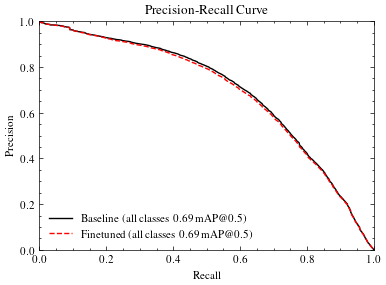

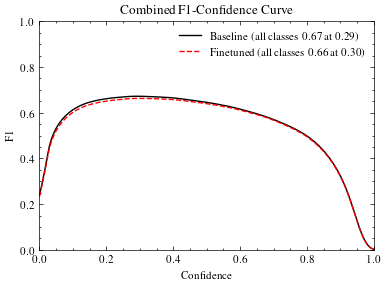

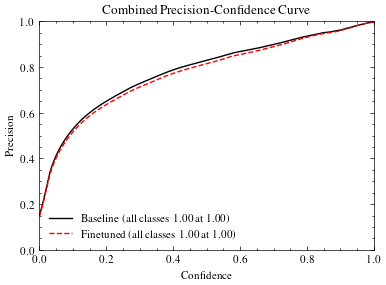

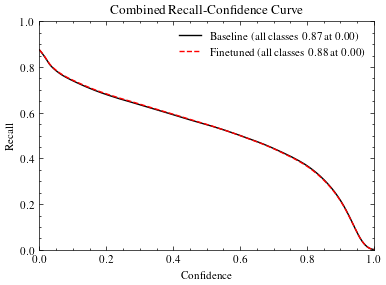

In [5]:
# Generate combined plots
plot_combined_pr_curve(data_dict, filename="combined_PR_curve")
plot_combined_mc_curve(data_dict, filename="combined_F1_curve", ylabel="F1")
plot_combined_mc_curve(data_dict, filename="combined_P_curve", ylabel="Precision", key="p")
plot_combined_mc_curve(data_dict, filename="combined_R_curve", ylabel="Recall", key="R")

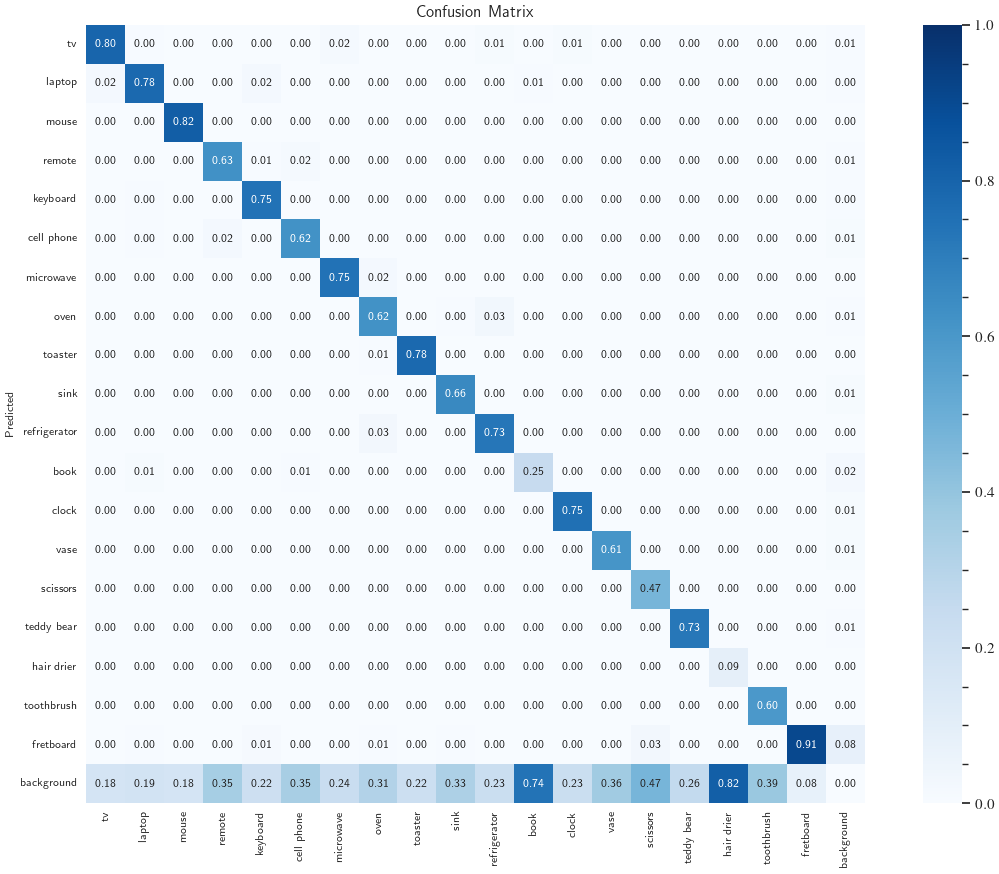

In [6]:
def plot_confusion_matrix(
    confusion_matrix: dict,
    subset=20,
    normalize=True,
    filename="confusion_matrix",
    format="pdf",
    show=True,
) -> None:
    import seaborn as sns

    sns.set_style("whitegrid", {"axes.grid": False})
    if not normalize:
        array = confusion_matrix["array"]
    else:
        array = confusion_matrix["array_normalized"]

    ticklabels = confusion_matrix["ticklabels"]

    # If subset is defined, take subset rows starting from the end
    array = array[-subset:, -subset:]
    ticklabels = ticklabels[-subset:]

    fig, ax = plt.subplots(1, 1, figsize=(12, 9), tight_layout=True)
    nc = len(ticklabels)  # number of classes
    sns.set(font_scale=1.0 if nc < 50 else 0.8)  # for label size
    with catch_warnings(), sns.axes_style("white"):
        # suppress empty matrix RuntimeWarning: All-NaN slice encountered
        simplefilter("ignore")
        sns.heatmap(
            array,
            ax=ax,
            annot=nc < 30,
            annot_kws={"size": 8},
            cmap="Blues",
            fmt=".2f",
            square=True,
            vmin=0.0,
            vmax=1.0 if normalize else None,
            xticklabels=ticklabels,
            yticklabels=ticklabels,
        ).set_facecolor((1, 1, 1))

    ax.set_ylabel("True")
    ax.set_ylabel("Predicted")
    ax.set_title("Confusion Matrix")
    ax.grid(False)
    if show:
        plt.show()
    savefig(fig, filename, format, bbox_inches="tight")
    plt.close(fig)


confusion_matrix = "Finetuned"
confusion_matrix = confusion_matrix_dict[confusion_matrix]
plot_confusion_matrix(confusion_matrix)

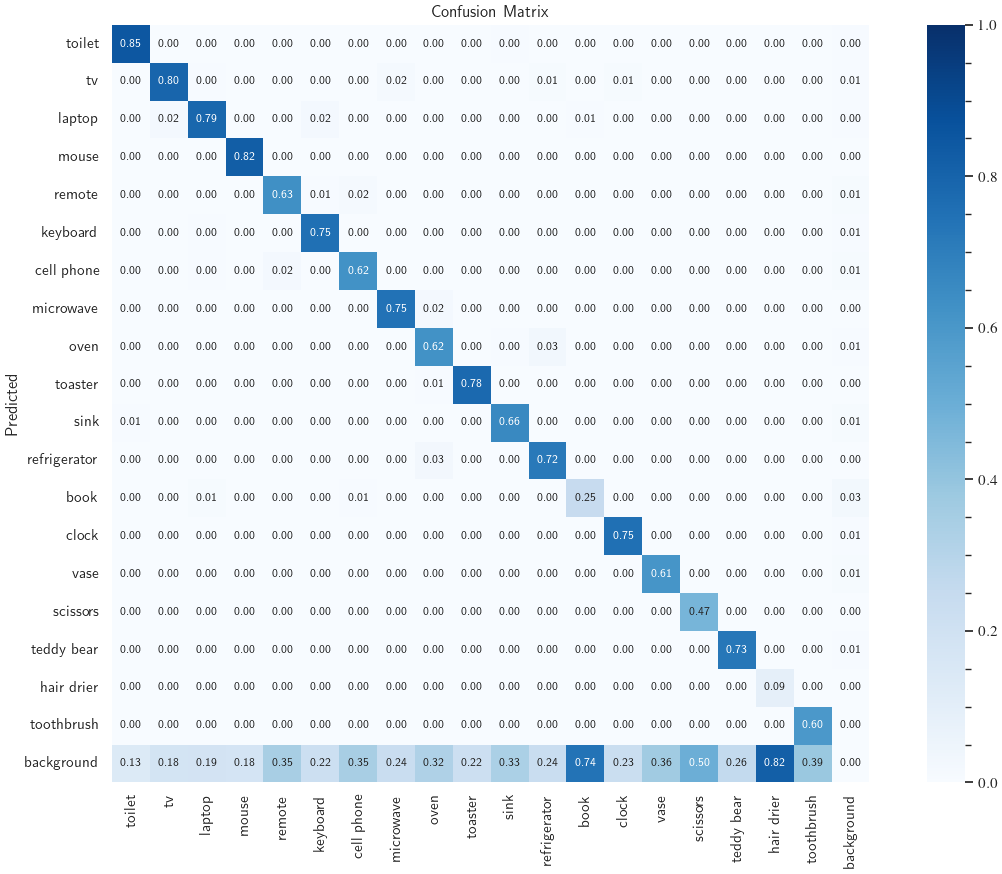

In [7]:
confusion_matrix = "Baseline"
confusion_matrix = confusion_matrix_dict[confusion_matrix]
plot_confusion_matrix(confusion_matrix)

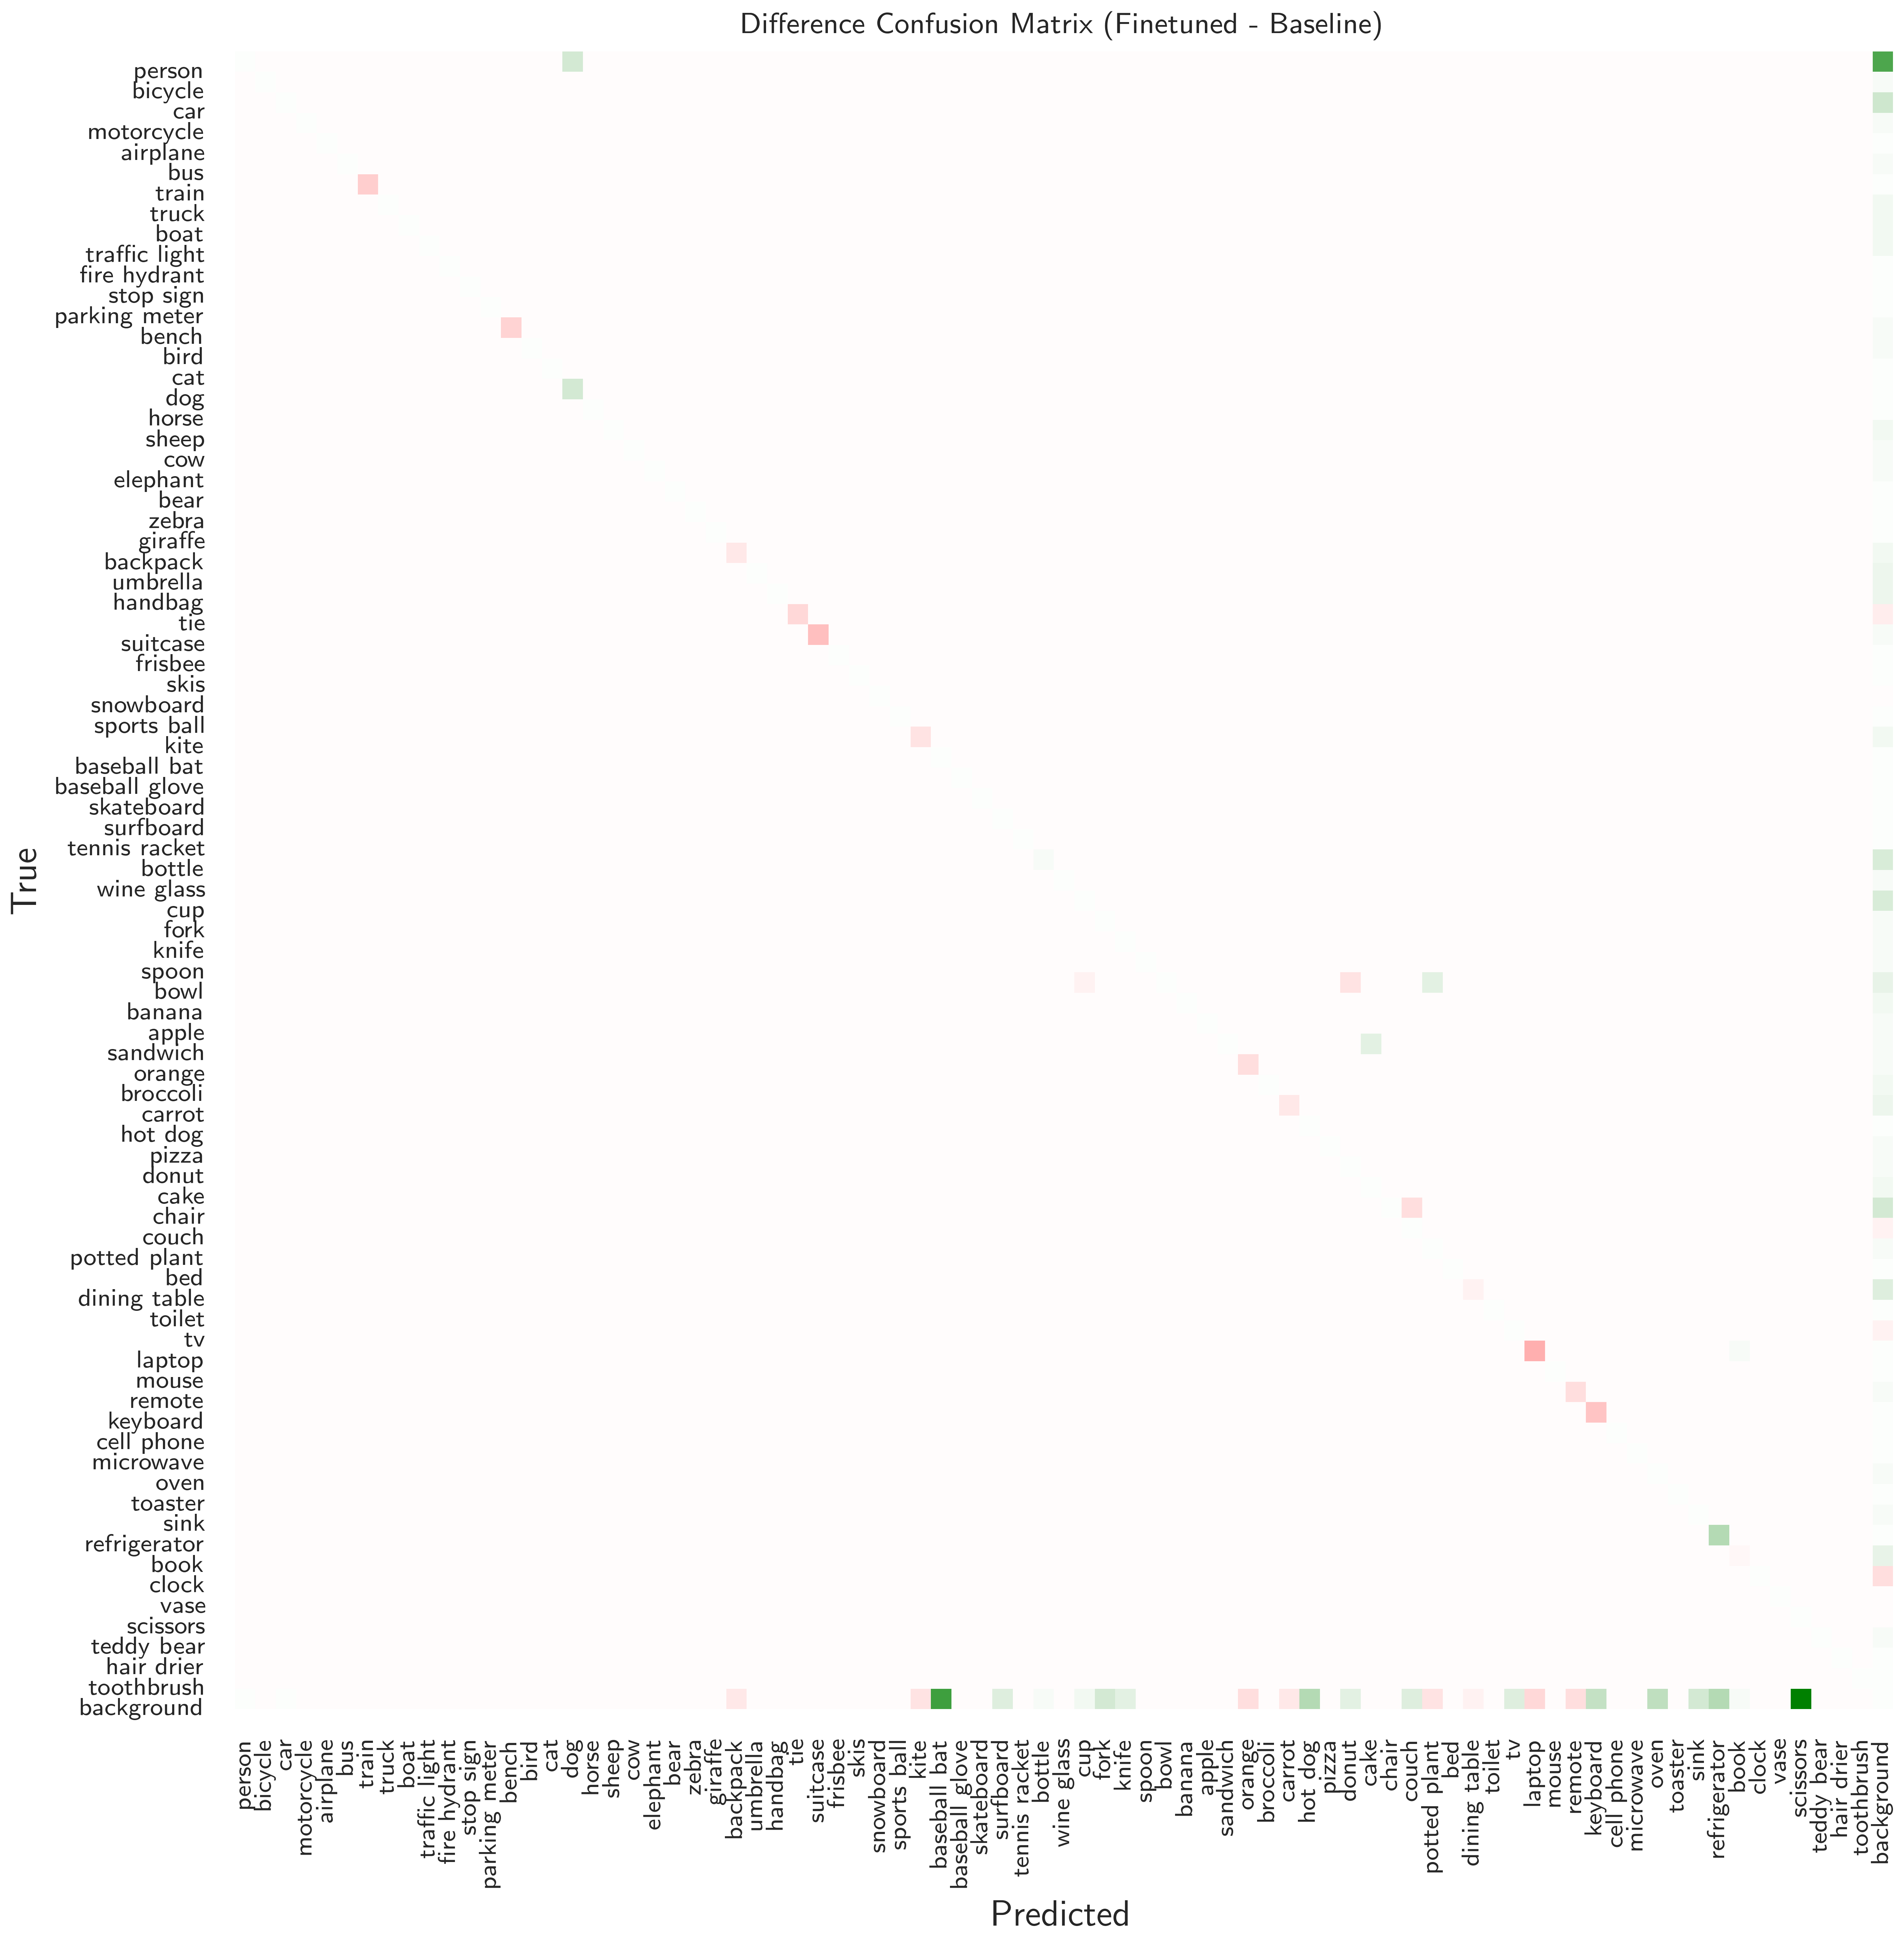

In [8]:
def plot_difference_confusion_matrix(
    finetuned_matrix: dict,
    baseline_matrix: dict,
    subset=None,
    colorbar=False,
    filename="difference_confusion_matrix",
    format="pdf",
    show=True,
) -> None:
    import seaborn as sns
    import numpy as np
    import matplotlib.pyplot as plt
    from matplotlib.colors import LinearSegmentedColormap

    sns.set_style("whitegrid", {"axes.grid": False})

    if subset is None:
        subset = baseline_matrix["array"].shape[0]

    # Ensure both matrices are normalized
    finetuned_array = finetuned_matrix["array_normalized"]
    baseline_array = baseline_matrix["array_normalized"]

    # Remove the "fretboard" row and column from the finetuned matrix
    finetuned_array = np.delete(finetuned_array, -2, axis=0)
    finetuned_array = np.delete(finetuned_array, -2, axis=1)

    # Ensure the shapes match
    assert (
        finetuned_array.shape == baseline_array.shape
    ), "Matrices must have the same shape after adjustment"

    # Calculate the difference
    diff_array = finetuned_array - baseline_array

    ticklabels = baseline_matrix["ticklabels"]

    # If subset is defined, take subset rows starting from the end
    diff_array = diff_array[-subset:, -subset:]

    ticklabels = ticklabels[-subset:]

    fig, ax = plt.subplots(1, 1, figsize=(12, 9), tight_layout=True, dpi=600)
    nc = len(ticklabels)  # number of classes
    sns.set(font_scale=1.0 if nc < 50 else 0.8)  # for label size

    # Create custom colormaps
    diagonal_colors = ["red", "white", "green"]
    off_diagonal_colors = ["green", "white", "red"]
    n_bins = 100
    diagonal_cmap = LinearSegmentedColormap.from_list("diagonal", diagonal_colors, N=n_bins)
    off_diagonal_cmap = LinearSegmentedColormap.from_list(
        "off_diagonal", off_diagonal_colors, N=n_bins
    )

    # Determine vmin and vmax based on the maximum absolute difference
    abs_max = np.max(np.abs(diff_array))
    vmin, vmax = -abs_max, abs_max

    # Create a masked array for diagonal and off-diagonal elements
    mask = np.eye(nc, dtype=bool)
    diagonal_data = np.ma.masked_array(diff_array, ~mask)
    off_diagonal_data = np.ma.masked_array(diff_array, mask)

    with plt.rc_context({"axes.grid": False}):
        # Plot diagonal elements
        sns.heatmap(
            diagonal_data,
            ax=ax,
            mask=~mask,
            cmap=diagonal_cmap,
            vmin=vmin,
            vmax=vmax,
            cbar=False,
            annot=nc < 30,
            fmt=".2f",
            annot_kws={"size": 8},
            square=True,
        )

        # Plot off-diagonal elements
        sns.heatmap(
            off_diagonal_data,
            ax=ax,
            mask=mask,
            cmap=off_diagonal_cmap,
            vmin=vmin,
            vmax=vmax,
            cbar=False,
            annot=nc < 30,
            fmt=".2f",
            annot_kws={"size": 8},
            square=True,
        )

    ax.set_ylabel("True")
    ax.set_xlabel("Predicted")
    ax.set_title("Difference Confusion Matrix (Finetuned - Baseline)")
    ax.set_xticks(np.arange(nc) + 1)
    ax.set_yticks(np.arange(nc) + 1)
    ax.set_xticklabels(ticklabels, rotation=90, ha="right", fontsize=8)
    ax.set_yticklabels(ticklabels, rotation=0, ha="right", fontsize=8)

    # Add two separate color bars
    if colorbar:
        fig.subplots_adjust(right=0.85)
        cax1 = fig.add_axes([0.87, 0.55, 0.03, 0.3])
        cax2 = fig.add_axes([0.87, 0.15, 0.03, 0.3])

        sm1 = plt.cm.ScalarMappable(cmap=diagonal_cmap, norm=plt.Normalize(vmin=vmin, vmax=vmax))
        sm2 = plt.cm.ScalarMappable(cmap=off_diagonal_cmap, norm=plt.Normalize(vmin=vmin, vmax=vmax))

        cbar1 = fig.colorbar(sm1, cax=cax1)
        cbar2 = fig.colorbar(sm2, cax=cax2)

        cbar1.set_ticks([vmin, 0, vmax])
        cbar1.set_ticklabels(["Worse", "No change", "Better"])
        cbar1.ax.set_title("Diagonal", fontsize=10)

        cbar2.set_ticks([vmin, 0, vmax])
        cbar2.set_ticklabels(["Better", "No change", "Worse"])
        cbar2.ax.set_title("Off-Diagonal", fontsize=10)

    if show:
        plt.show()
    savefig(fig, filename, format, bbox_inches="tight")
    plt.close(fig)


finetuned_matrix = confusion_matrix_dict["Finetuned"]
baseline_matrix = confusion_matrix_dict["Baseline"]
plot_difference_confusion_matrix(finetuned_matrix, baseline_matrix)